# Outlier detection

## Choose and generate dataset

In [1]:
from keras.layers import Input, Dense
from keras.models import Model

from matplotlib.colors import Normalize

from sklearn import datasets, metrics, preprocessing, svm
from sklearn.covariance import EllipticEnvelope
from sklearn.datasets import load_iris
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, make_scorer, recall_score, roc_auc_score
from sklearn.metrics import average_precision_score, classification_report, precision_recall_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
#A changer selon l'ordinateur
pathtodata='./Data_OK/'

In [3]:
datasetsnames=["generated","creditcard","http","kdd10","kdd","smtp"]

#Changer le numéro pour choisir le nom
datasetname=datasetsnames[1]

- N.B. : creditcard ne fonctionne pas pour LocalOutlierFactor
- kdd est trop gros (fonctionne pour 40% pour 16 GB RAM), utiliser seulement kdd10
- smtp ne présente que 3 outliers, inintéressant

In [4]:
def column_generator(nbvar):
    SAcolumns=[]
    for i in range(1,nbvar+1):
        SAcolumns.append("var_{}".format(i))
    SAcolumns.append("label")
    return SAcolumns

def data_set(dataname):
    if dataname=="generated":
        return pd.read_csv(pathtodata+'Data_2.csv', low_memory=False)
    elif dataname=="creditcard":
        return pd.read_csv(pathtodata+'creditcard_2.csv', low_memory=False)
    elif dataname=="smtp" or dataname=="http" or dataname=="SA" or dataname=="SF":
        dataset=datasets.fetch_kddcup99(subset=dataname, data_home=None, shuffle=False, random_state=None, percent10=True, download_if_missing=True)
        data=dataset['data']
        target=dataset['target']
        data=np.append(data,np.array(target).reshape(-1,1),axis=1)
        if dataname=="smtp" or dataname=="http":
            return pd.DataFrame(data=data,columns=column_generator(3))
        elif dataname=="SF":
            return pd.DataFrame(data=data,columns=column_generator(4))
        elif dataname=="SA":
            return pd.DataFrame(data=data,columns=column_generator(41))
    elif dataname=="kdd10":
        return pd.read_csv(pathtodata+'kddcup.data_10_percent_corrected.csv', header=None, low_memory=False)
    elif dataname=="kdd":
        return pd.read_csv(pathtodata+'kddcup.data.corrected.csv', header=None, low_memory=False)

In [5]:
data=data_set(datasetname)

## Making our data one-class

1) Convert the outliers into class 1 (normal) and class -1 (outlier) <br>
2) Copy outlier labels to evaluate performance later <br>
3) Compute proportion of outliers <br>
4) Drop label and useless columns from the dataframe, to do unsupervised training with unlabelled data

In [6]:
all_label_columns = {"generated": 'label',
                      "creditcard": 'label',
                      "kdd10": 41,
                      "kdd": 41,
                      "smtp": 'label', 
                      "http": 'label',
                      "SA": 'label',
                      "SF": 'label'}
all_normal_labels = {"generated": "b'0'",
                       "creditcard": 0,
                       "kdd10": "normal.",
                       "kdd": "normal.", 
                       "smtp": b'normal.', 
                       "http": b'normal.', 
                       "SA": b'normal.', 
                       "SF": b'normal.'}

label_column = all_label_columns[datasetname]
normal_label = all_normal_labels[datasetname]

normal_value = -1
outlier_value = 1

data.loc[data[label_column] != normal_label, "outlier"] = outlier_value
data.loc[data[label_column] == normal_label, "outlier"] = normal_value
if datasetname=="kdd10" or datasetname=="kdd":
    data.loc[data[label_column] == "smurf.", "outlier"] = normal_value 
    data.loc[data[label_column] == "neptune.", "outlier"] = normal_value 

target = data['outlier']

outliers = target[target == outlier_value]  
print("outliers.shape", outliers.shape)  
print("outlier fraction", outliers.shape[0]/target.shape[0])

all_useless_columns = {"generated": ["label", "outlier"],
                     "creditcard": ["Time", "label", "outlier"],
                     "kdd10": [41, 1, 2, 3, "outlier"],
                     "kdd": [41, 1, 2, 3, "outlier"],  
                     "smtp": ["label", "outlier"], 
                     "http": ["label", "outlier"], 
                     "SA": ["label", "var_2", "var_3", "var_4", "outlier"], 
                     "SF": ["label", "var_2", "outlier"]
                    }

useless_columns = all_useless_columns[datasetname]
data.drop(useless_columns, axis=1, inplace=True)

print(data.shape) 

outliers.shape (492,)
outlier fraction 0.001727485630620034
(284807, 29)


## Proportion of outliers

In [7]:
nu = outliers.shape[0] / target.shape[0]  
print("nu = ", nu)

nu =  0.001727485630620034


## Normalize data

In [8]:
def normalized_data(data, type_normalization):
    if type_normalization=="normalizer":
        return normalize(data,axis=0)
    elif type_normalization=="minmaxscaler":
        min_max_scaler = preprocessing.MinMaxScaler()
        return min_max_scaler.fit_transform(data)
    elif type_normalization=="standardscaler":
        standard_scaler = preprocessing.StandardScaler()
        return standard_scaler.fit_transform(data)
    elif type_normalization==False:
        return data

In [9]:
normalization_types = ["normalizer","minmaxscaler","standardscaler",False]

#Choisir la normalisation minmaxscaler pour Autoencoder
chosen_normalization = normalization_types[2] 

In [10]:
data = normalized_data(data, chosen_normalization)

## Shuffling and splitting data into training and test sets

In [11]:
def data_split(data,target,ratio):
    if 0<ratio and ratio<1:
        X_train, X_test, y_train, y_test = train_test_split(data, target, shuffle = True, train_size = ratio)
    elif ratio==1:
        X_train, X_test, y_train, y_test = data, data, target, target
    return X_train, X_test, y_train, y_test

In [12]:
X_train, X_test, y_train, y_test = data_split(data, target, 1)

In [13]:
X_train.shape

(284807, 29)

## Profit function

In [14]:
def profit(y_true,y_pred,verbose=True):
    true_positive = np.sum(np.where(np.logical_and(y_true==1,y_pred==1),1,0))
    false_positive = np.sum(np.where(np.logical_and(y_true==-1,y_pred==1),1,0))
    positive = np.sum(np.where(y_true==1,1,0))
    negative = len(y_true)-positive
    if verbose:
        print("True Positive Rate: ", true_positive/positive)
        print("Number of False Positive: ", false_positive)
        print("False Positive Rate: ", false_positive/negative)
        print()
    return 160*(2*true_positive/positive-1) - 160*false_positive/negative

## Training the model

$\nu$ is the proportion of outliers in our dataset.

In [15]:
nu = outliers.shape[0] / target.shape[0]  
print("nu = ", nu)

nu =  0.001727485630620034


In [16]:
def choose_classifier(classifier_name):
    if classifier_name == "OneClassSVM":
        return svm.OneClassSVM(nu=nu,kernel='rbf', gamma=0.1,max_iter=1000) 
    elif classifier_name == "IsolationForest":
        return IsolationForest(contamination=0.478947368421)
    elif classifier_name == "LocalOutlierFactor":
        return LocalOutlierFactor(n_neighbors=20,contamination=nu)
    elif classifier_name == "EllipticEnvelope":
        return EllipticEnvelope(contamination = nu)
    elif classifier_name == "Autoencoder":
        encoding_dim = int(0.8*X_train.shape[1])
        input = Input(shape=(X_train.shape[1],)) 
        encoded_1 = Dense(encoding_dim, activation='relu')(input)
        decoded_2 = Dense(X_train.shape[1], activation='sigmoid')(encoded_1)
        autoencoder = Model(inputs=input, outputs=decoded_2)
        encoder = Model(inputs=input, outputs=encoded_1)
        autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
        return autoencoder

In [17]:
list_classifiers=["OneClassSVM","IsolationForest","LocalOutlierFactor","EllipticEnvelope","Autoencoder"]

#Changer le numéro pour choisir le nom
chosen_classifier = list_classifiers[1]

In [18]:
classifier = choose_classifier(chosen_classifier)

## Compute score

In [19]:
def compute_score(classifier_name):
    if classifier_name == "LocalOutlierFactor":
        classifier.fit(X_train)
        return classifier.negative_outlier_factor_
    elif classifier_name == "Autoencoder":
        #Ajuster epochs au dataset d'entrée
        classifier.fit(X_train, X_train,epochs=100,batch_size=X_train.shape[1],shuffle=True,verbose=1) 
        decoded = classifier.predict(X_train)
        dist = np.zeros(X_train.shape[0])
        for i, x in enumerate(X_train):
            dist[i] = np.linalg.norm(x-decoded[i], ord = np.inf)
        return dist
    else:
        return normal_value*classifier.fit(X_train).decision_function(X_test)

In [20]:
y_score=compute_score(chosen_classifier)

## Checking accuracy of the model

In [21]:
def show_results(y_pred, y_true):
    print("Results on train data")
    print("accuracy: ", round(metrics.accuracy_score(y_true, y_pred),3))  
    print("precision: ", round(metrics.precision_score(y_true, y_pred),3))  
    print("recall: ", round(metrics.recall_score(y_true, y_pred),3))  
    print("f1: ", round(metrics.f1_score(y_true, y_pred),3))  
    print("area under curve (auc): ", round(metrics.roc_auc_score(y_true, y_score),3))
    print()

In [22]:
def compute_pred(classifier_name) :
    if classifier_name == "LocalOutlierFactor":
        return classifier.fit_predict(X_train)
    elif classifier_name == "Autoencoder":
        threshold = 0.08 #A ajuster
        return np.where(y_score >= threshold,1,-1)
    else:
        return normal_value*classifier.predict(X_train)

### On train data

In [23]:
y_pred = compute_pred(chosen_classifier)
y_true = y_train
show_results(y_pred,y_true)

Results on train data
accuracy:  0.523
precision:  0.003
recall:  0.963
f1:  0.007
area under curve (auc):  0.948



### On test data

In [24]:
y_pred = compute_pred(chosen_classifier)
y_true = y_test
show_results(y_pred,y_true)

Results on train data
accuracy:  0.523
precision:  0.003
recall:  0.963
f1:  0.007
area under curve (auc):  0.948



## Plot ROC curve

$x = $ false positive rate, $y = $ true positive rate

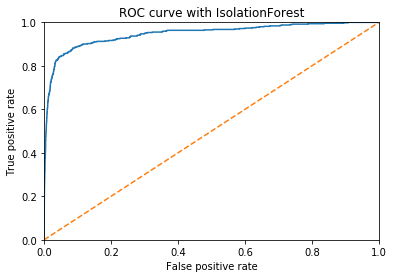

In [25]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
# metrics.roc_auc_score
x = np.linspace(0,1,500)
plt.plot(fpr,tpr)
plt.plot(x,x,'--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('ROC curve with {}'.format(chosen_classifier))
plt.savefig("ROC_curve_{}_{}.png".format(datasetname,chosen_classifier), bbox_inches='tight')
plt.show()

## Plot score

In [26]:
def draw_performance():
    inliers, outliers, inliers_scores, outliers_scores = [], [], [], []
    for i in range(len(target)):
        if target[i] == normal_value:
            inliers.append(i)
            inliers_scores.append(y_score[i])
        else:
            outliers.append(i)
            outliers_scores.append(y_score[i])
    plt.scatter(inliers,inliers_scores,c='blue',label="Inliers")
    plt.scatter(outliers,outliers_scores,c='red',label="Outliers")
    plt.legend()
    plt.title("Outlier score")
    plt.xlabel('Index')
    plt.ylabel('Score')
    plt.savefig("Plot_score_{}_{}.png".format(datasetname,chosen_classifier), bbox_inches='tight')

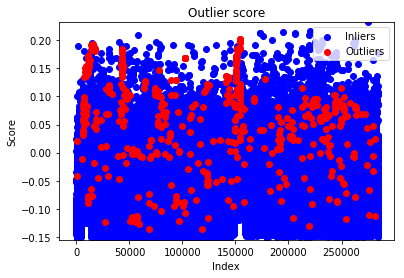

In [27]:
plt.ylim(min(y_score),max(y_score))
draw_performance()
plt.show()

## Plot Precision-Recall curve

In [28]:
average_precision = average_precision_score(y_test, y_score)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall,thresholds  = precision_recall_curve(y_test, y_score)
# f1_score = 2*precision*recall/(precision+recall)
# max_f1_score = max(f1_score)
# index_max = np.where(f1_score == max(f1_score))[0][0]
# print(precision[index_max],recall[index_max])

Average precision-recall score: 0.15


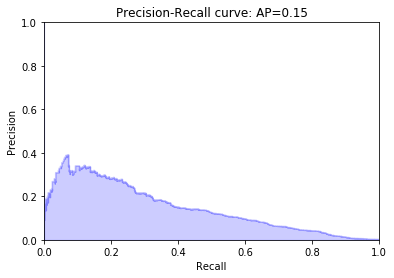

In [29]:
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()